In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scienceplots

from common import NGSpiceRaw, FIG_WIDTH, figure_save

%matplotlib widget

In [2]:
plt.style.use(["science", "grid"])
plt.style.use({
    'font.size': 14,                   # Slightly larger base font
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12
})

In [3]:
data = NGSpiceRaw("simulation/tgate_tb.raw", live=False)
print("Fields:", data.names)

Loaded 1 plots from simulation/tgate_tb.raw
Fields: ('time', 'v(vdd)', 'v(vss)', 'v(x1.ctrl_ni)', 'v(ctrl)', 'v(x1.x2.net1)', 'v(x1.ctrl_i)', 'v(out_p)', 'v(in_p)', 'v(x2.ctrl_ni)', 'v(x2.x2.net1)', 'v(x2.ctrl_i)', 'v(out_n)', 'v(in_n)', 'i(vctrl)', 'i(vinn)', 'i(vinp)', 'i(vss)', 'i(vdd)', 'v(n.x2.xm1.nsg13_lv_pmos#NOI)', 'v(n.x2.xm1.nsg13_lv_pmos#GP)', 'v(n.x2.xm1.nsg13_lv_pmos#SI)', 'v(n.x2.xm1.nsg13_lv_pmos#DI)', 'v(n.x2.xm1.nsg13_lv_pmos#BP)', 'v(n.x2.xm1.nsg13_lv_pmos#BI)', 'v(n.x2.xm1.nsg13_lv_pmos#BS)', 'v(n.x2.xm1.nsg13_lv_pmos#BD)', 'v(n.x2.xm1.nsg13_lv_pmos#INT1)', 'v(n.x2.xm1.nsg13_lv_pmos#INT2)', 'v(n.x2.xm1.nsg13_lv_pmos#INT3)', 'v(n.x2.xm1.nsg13_lv_pmos#INT4)', 'v(n.x2.xm1.nsg13_lv_pmos#INT5)', 'v(n.x2.xm1.nsg13_lv_pmos#INT6)', 'v(n.x2.xm1.nsg13_lv_pmos#INT7)', 'v(n.x2.xm1.nsg13_lv_pmos#INT8)', 'v(n.x2.xm1.nsg13_lv_pmos#INT9)', 'v(n.x2.xm1.nsg13_lv_pmos#flow(RES1))', 'v(n.x2.xm1.nsg13_lv_pmos#flow(SPLINE1))', 'v(n.x2.xm1.nsg13_lv_pmos#flow(RES2))', 'v(n.x2.xm1.nsg13_lv_p

In [4]:
F_SAMPLING = 80e6
N = 128
BASE_HARMONIC = 3
CONVERSION_CYCLES = 2
F_SIGNAL = F_SAMPLING / N * BASE_HARMONIC / CONVERSION_CYCLES

print("Signal frequency:", F_SIGNAL, "Hz")

Signal frequency: 937500.0 Hz


In [5]:
times = data['time']
vin_n = data['v(in_n)']
vin_p = data['v(in_p)']
vout_n = data['v(out_n)']
vout_p = data['v(out_p)']

In [6]:
vin = vin_p - vin_n
vout = vout_p - vout_n

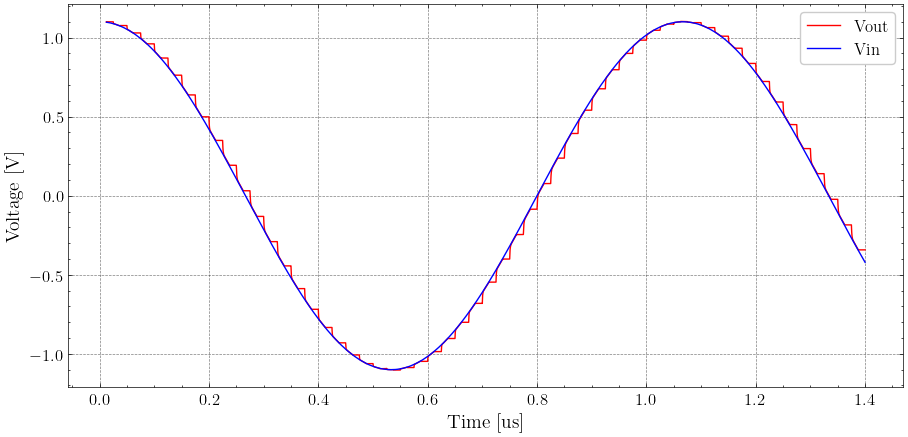

In [ ]:
plt.figure(figsize=(FIG_WIDTH, FIG_WIDTH * 0.5))
plt.plot(times[50:4000] * 1e6, vout[50:4000], label='Vout', color='red')
plt.plot(times[50:4000] * 1e6, vin[50:4000], label='Vin', color='blue')
# plt.title('Input and Output Voltages')
plt.xlabel('Time [us]')
plt.ylabel('Voltage [V]')
plt.legend()
plt.tight_layout()
plt.show()

# figure_save(plt.gcf(), "tgate_in_out")

Number of samples: 128
Frequency bin size: 312500.0
Sampling error (p-p): 8.0 mV


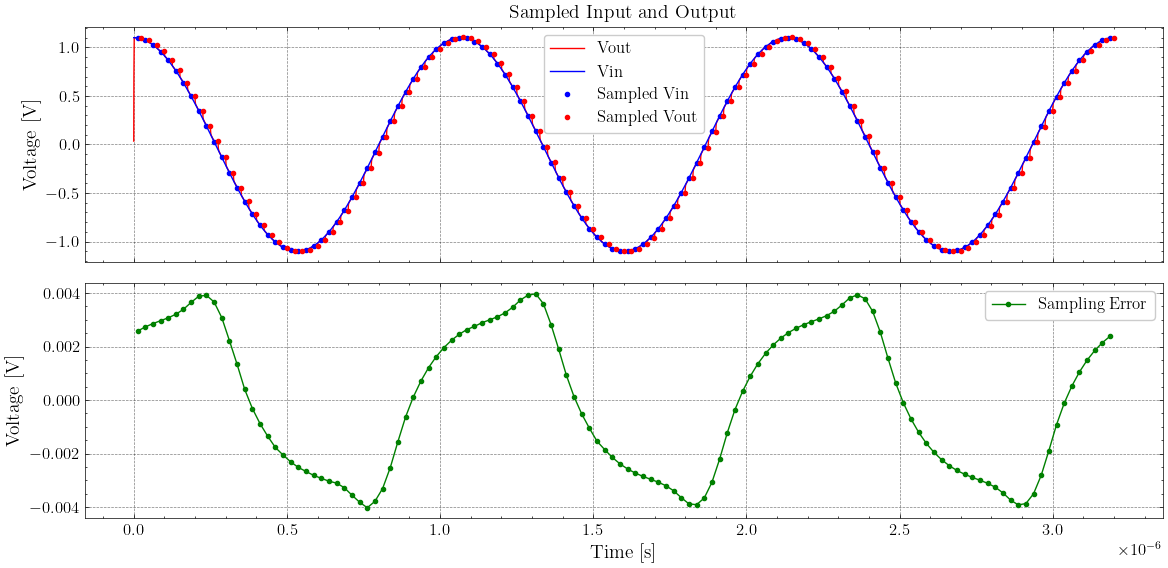

In [8]:
sampling_times_in = [0.99 / F_SAMPLING]
while sampling_times_in[-1] < times[-1]:
    sampling_times_in.append(sampling_times_in[-1] + CONVERSION_CYCLES / F_SAMPLING)

sampling_times_out = [(CONVERSION_CYCLES - 0.01) / F_SAMPLING]
while sampling_times_out[-1] < times[-1]:
    sampling_times_out.append(sampling_times_out[-1] + CONVERSION_CYCLES / F_SAMPLING)

sampling_times_in = np.array(sampling_times_in)[:-1] # Remove the last time to avoid oversampling
sampling_times_out = np.array(sampling_times_out)[:-1] # Remove the last time to avoid oversampling
sampling_vin = np.interp(sampling_times_in, times, vin)
sampling_vout = np.interp(sampling_times_out, times, vout)
sampling_times_in = sampling_times_in
sampling_times_out = sampling_times_out
sampling_error = sampling_vout - sampling_vin

assert N == len(sampling_times_in)
assert N == len(sampling_times_out)
f_bin = F_SAMPLING / N / CONVERSION_CYCLES
print("Number of samples:", N)
print("Frequency bin size:", f_bin)
print(f"Sampling error (p-p): {(np.max(sampling_error) - np.min(sampling_error))*1e3:.1f} mV")

fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
ax[0].plot(times, vout, label='Vout', color='red', linewidth=1)
ax[0].plot(times, vin, label='Vin', color='blue', linewidth=1)
ax[0].plot(sampling_times_in, sampling_vin, label='Sampled Vin', color='blue', marker='o', markersize=3, linestyle='None')
ax[0].plot(sampling_times_out, sampling_vout, label='Sampled Vout', color='red', marker='o', markersize=3, linestyle='None')
ax[0].set_title('Sampled Input and Output')
ax[0].set_ylabel('Voltage [V]')
ax[0].legend()
ax[1].plot(sampling_times_in, sampling_error, label='Sampling Error', color='green', marker='o', markersize=3)
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Voltage [V]')
ax[1].legend()
plt.tight_layout()
plt.show()

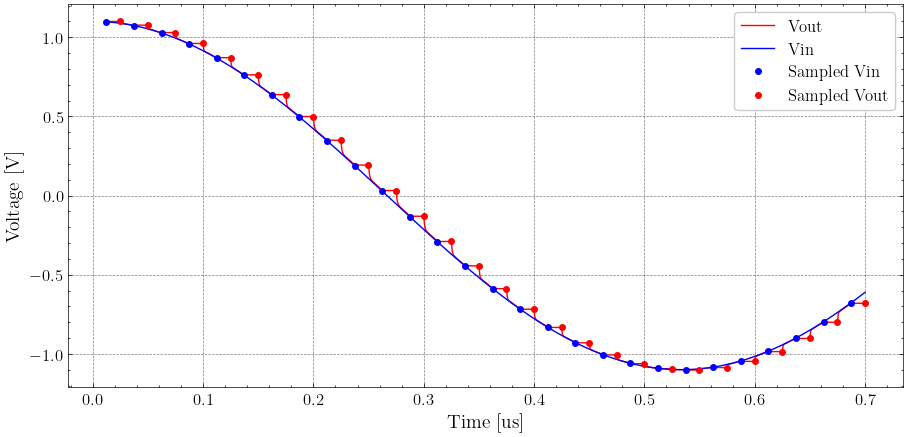

In [39]:
plt.figure(figsize=(FIG_WIDTH, FIG_WIDTH * 0.5))
# plt.plot(times[50:4000] * 1e6, vout[50:4000], label='Vout', color='red')
# plt.plot(times[50:4000] * 1e6, vin[50:4000], label='Vin', color='blue')
# plt.plot(np.array(sampling_times_in[:56]) * 1e6, sampling_vin[:56], label='Sampled Vin', color='blue', marker='o', markersize=3, linestyle='None')
# plt.plot(np.array(sampling_times_out[:56]) * 1e6, sampling_vout[:56], label='Sampled Vout', color='red', marker='o', markersize=3, linestyle='None')
plt.plot(times[50:2000] * 1e6, vout[50:2000], label='Vout', color='red')
plt.plot(times[50:2000] * 1e6, vin[50:2000], label='Vin', color='blue')
plt.plot(np.array(sampling_times_in[:28]) * 1e6, sampling_vin[:28], label='Sampled Vin', color='blue', marker='o', markersize=4, linestyle='None')
plt.plot(np.array(sampling_times_out[:28]) * 1e6, sampling_vout[:28], label='Sampled Vout', color='red', marker='o', markersize=4, linestyle='None')
# plt.title('Input and Output Voltages')
plt.xlabel('Time [us]')
plt.ylabel('Voltage [V]')
plt.legend()
plt.tight_layout()
plt.show()

figure_save(plt.gcf(), "tgate_in_out")

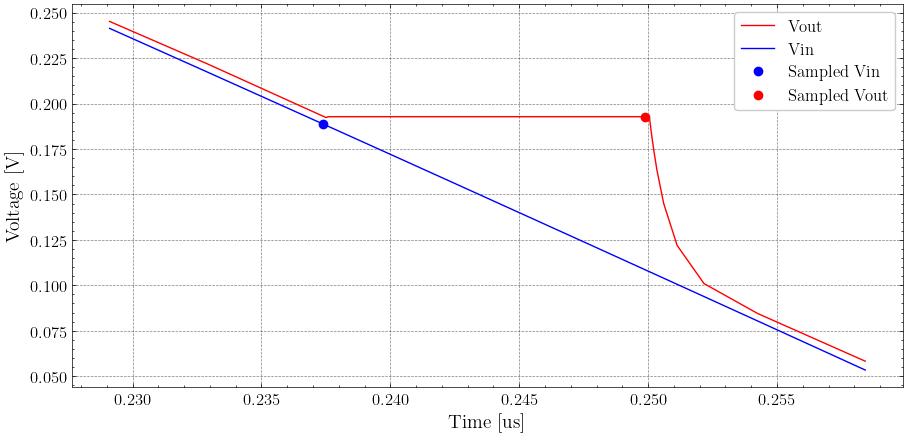

In [38]:
SI = 718
EI = 795

plt.figure(figsize=(FIG_WIDTH, FIG_WIDTH * 0.5))
plt.plot(times[SI:EI] * 1e6, vout[SI:EI], label='Vout', color='red')
plt.plot(times[SI:EI] * 1e6, vin[SI:EI], label='Vin', color='blue')
plt.plot(sampling_times_in[9] * 1e6, sampling_vin[9], label='Sampled Vin', color='blue', marker='o', markersize=6, linestyle='None')
plt.plot(sampling_times_out[9]* 1e6, sampling_vout[9], label='Sampled Vout', color='red', marker='o', markersize=6, linestyle='None')
# plt.title('Input and Output Voltages')
plt.xlabel('Time [us]')
plt.ylabel('Voltage [V]')
plt.legend()
plt.tight_layout()
plt.show()

figure_save(plt.gcf(), "tgate_in_out_zoom")

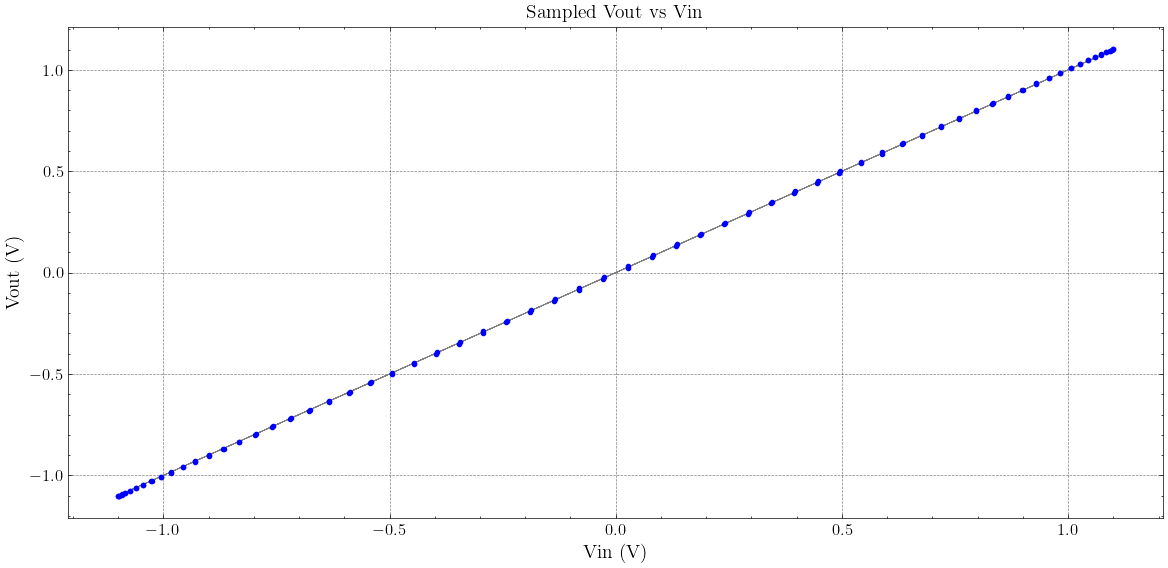

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(sampling_vin[:-1], sampling_vin[:-1], color='gray', linewidth=0.5)
plt.plot(sampling_vin[:-1], sampling_vout[:-1], marker='o', markersize=3, linestyle='None', color='blue')
plt.title('Sampled Vout vs Vin')
plt.xlabel('Vin (V)')
plt.ylabel('Vout (V)')
plt.tight_layout()
plt.show()

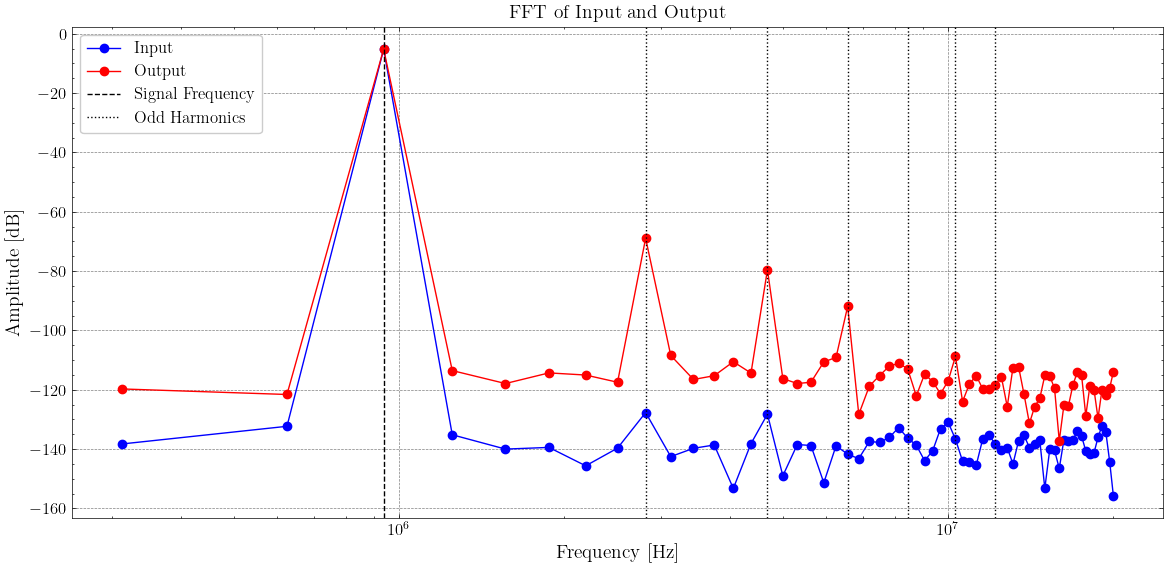

In [10]:
# FFT of input and output signals
yf_vin = np.fft.rfft(sampling_vin) / N
yf_vout = np.fft.rfft(sampling_vout) / N
xf = np.fft.rfftfreq(N, CONVERSION_CYCLES / F_SAMPLING)

yf_vin = np.abs(yf_vin[xf > 0])
yf_vout = np.abs(yf_vout[xf > 0])
xf = xf[xf > 0]

plt.figure(figsize=(12, 6))
plt.plot(xf, 20 * np.log10(yf_vin), 'o-', label='Input', color='blue', linewidth=1)
plt.plot(xf, 20 * np.log10(yf_vout), 'o-', label='Output', color='red', linewidth=1)
# plt.plot(xf, 20 * np.log10(yf_vout) - 20 * np.log10(yf_vin), 'o-', label='Error', color='green', linewidth=1)
plt.axvline(F_SIGNAL, color='black', linestyle='--', label='Signal Frequency')
plt.axvline(F_SIGNAL * 3, color='black', linestyle='dotted', label='Odd Harmonics')
plt.axvline(F_SIGNAL * 5, color='black', linestyle='dotted')
plt.axvline(F_SIGNAL * 7, color='black', linestyle='dotted')
plt.axvline(F_SIGNAL * 9, color='black', linestyle='dotted')
plt.axvline(F_SIGNAL * 11, color='black', linestyle='dotted')
plt.axvline(F_SIGNAL * 13, color='black', linestyle='dotted')
plt.title('FFT of Input and Output')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
# plt.xlim(0, 1.5 * F_SIGNAL)
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# # yf_vin = np.fft.rfft(sampling_vin) / N
# # yf_vout = np.fft.rfft(sampling_vout) / N
# # xf = np.fft.rfftfreq(N, CONVERSION_CYCLES / F_SAMPLING)

# # yf_vin = np.abs(yf_vin[xf > 0])
# # yf_vout = np.abs(yf_vout[xf > 0])
# # xf = xf[xf > 0]

# signal_amp_in = np.abs(yf_vin[BASE_HARMONIC - 1]) ** 2 # -1 because of zero frequency component
# signal_amp_out = np.abs(yf_vout[BASE_HARMONIC - 1]) ** 2

# print(f"Signal power (Vin):  {20 * np.log10(signal_amp_in):.2f} dB")
# print(f"Signal power (Vout): {20 * np.log10(signal_amp_out):.2f} dB")

# harmonics_indexes = np.arange(BASE_HARMONIC * 2, (len(yf_vin) // BASE_HARMONIC) * BASE_HARMONIC, BASE_HARMONIC)

# # print(f"Harmonics indexes: {harmonics_indexes}")

# harmonics_in = np.abs(yf_vin[harmonics_indexes - 1]) ** 2
# harmonics_out = np.abs(yf_vout[harmonics_indexes - 1]) ** 2

# # np.save('harmonics1024.npy', harmonics_out)

# plt.figure(figsize=(12, 6))
# plt.plot(harmonics_indexes / BASE_HARMONIC, 10 * np.log10(harmonics_in), 'o-', label='Input', color='blue', linewidth=1)
# plt.plot(harmonics_indexes / BASE_HARMONIC, 10 * np.log10(harmonics_out), 'o-', label='Output', color='red', linewidth=1)
# plt.grid()
# plt.title('Harmonics Power')
# plt.xlabel('Harmonic Index')
# plt.ylabel('Power [dB]')
# # plt.xscale('log')
# # plt.xticks(harmonics_indexes * f_bin, [f"{int(f)}" for f in harmonics_indexes * f_bin], rotation=45)
# plt.legend()
# plt.tight_layout()
# plt.show()

# harmonics_in = np.sum(harmonics_in)
# harmonics_out = np.sum(harmonics_out)

# print(f"Harm. power (Vin): {20 * np.log10(harmonics_in):.2f} dB")
# print(f"Harm. power (Vout): {20 * np.log10(harmonics_out):.2f} dB")

# sdr = signal_amp_out / harmonics_out
# print(f"SDR (Vout): {10 * np.log10(sdr):.2f} dB")
# print(f"ENOB (Vin): {(10 * np.log10(sdr) - 1.76) / 6.02:.2f} bits")

In [12]:
def compute_thd(signal, fundamental_index):
    N = len(signal)
    yf = np.fft.rfft(signal) / N
    
    fundamental_amplitude = np.abs(yf[fundamental_index])
    
    max_h = (len(yf) - 1) // fundamental_index
    harmonics_amplitude = np.sqrt(sum(np.abs(yf[h * fundamental_index])**2 for h in range(2, max_h + 1)))
    
    thd = harmonics_amplitude / fundamental_amplitude
    return thd

def compute_sdr(signal, fundamental_index):
    """
    SDR = P_signal / sum_h>=2 P_harmonic_h   (power ratio, in dB)
    Assumes each tone sits in exactly one FFT bin (no leakage).
    """
    N = len(signal)
    X = np.fft.rfft(signal)
    P = (np.abs(X) / N)**2

    P1 = P[fundamental_index]

    Ph = 0.0
    h = 2
    while h * fundamental_index < len(P):
        Ph += P[h * fundamental_index]
        h += 1

    return 10 * np.log10(P1 / Ph)

def compute_enob(signal, fundamental_index):
    return (compute_sdr(signal, fundamental_index) - 1.76) / 6.02

thd_vin = compute_thd(sampling_vin, BASE_HARMONIC)
thd_vout = compute_thd(sampling_vout, BASE_HARMONIC)
sdr_vin = compute_sdr(sampling_vin, BASE_HARMONIC)
sdr_vout = compute_sdr(sampling_vout, BASE_HARMONIC)
enob_vin = compute_enob(sampling_vin, BASE_HARMONIC)
enob_vout = compute_enob(sampling_vout, BASE_HARMONIC)

print("\tTHD\tSDR\t\tENOB")
print(f"Vin:\t{thd_vin:.2%}\t{sdr_vin:.2f} dB\t{enob_vin:.2f} bits")
print(f"Vout:\t{thd_vout:.2%}\t{sdr_vout:.2f} dB\t{enob_vout:.2f} bits")

	THD	SDR		ENOB
Vin:	0.00%	117.56 dB	19.24 bits
Vout:	0.07%	63.37 dB	10.23 bits


In [13]:
# Save fft and frequencies to file
np.savetxt("fft_vin.txt", np.column_stack((xf, yf_vin)), header="freq ampl", fmt='%.6e')
np.savetxt("fft_vout.txt", np.vstack((np.column_stack((xf, yf_vout)), (sdr_vout, enob_vout))), header="freq ampl", fmt='%.6e')